**Unzip the uploaded data files**

In [1]:
# !unzip "drive/MyDrive/Dog Vision/dog-breed-identification.zip" -d "drive/MyDrive/Dog Vision/"

# End-to-end multi-class Dog Breed Classification
This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.5.0 and TensorFlow Hub.

## 1. Problem
Identifing the breed of dog using a given image of the dog.
When I'm sitting in a cafe and I take a photo of a dog, I want to know what breed of dog it is.

## 2. Data
The data that we are using is from Kaggle's Dog Breed Identification competition.
https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation
Submissions are evaluated on Multi Class Log Loss between the predicted probability and the observed target.
https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

For each image in the test set, you must predict a probability for each of the different breeds. The file should contain a header and have the following format:

id,affenpinscher,afghan_hound,..,yorkshire_terrier
000621fb3cbb32d8935728e48679680e,0.0083,0.0,...,0.0083
etc.

## 4. Features
Some information about the data:
* We're dealing with images (unstructured data), so it's probably best we use Deep Learning / Transfer Learning.
* There are 120 breeds of dogs (This means there are 120 different classes.
* There are around 10,000+ images in the training set (These images have labels).
* There around 10,000+ images in the test set (these images will have no labels, because we want to predict them).



# Get our workspace ready

* Import TensorFLow
* Import TensorFlow Hub
* Make sure we'e using a GPU

In [2]:
# Import TensorFlow in Colab
import tensorflow as tf
print("TensorFlow Version: " + tf.__version__)

TensorFlow Version: 2.5.0


In [3]:
# Import TensorFlow Hub
import tensorflow_hub as hub
print("TensorFlow Hub Version: " + hub.__version__)

TensorFlow Hub Version: 0.12.0


In [4]:
# Check for GPU availability
# https://research.google.com/colaboratory/faq.html#gpu-availability
print("GPU", " available (YESS!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU  available (YESS!!!!!)


In [5]:
# Change Runtime Type to GPU
# Go to Runtime -> Chage Runtime Type -> Select GPU and save

## Getting our data read (turning it into tensors)

With all machine learning models our data has to be in numerical format. So that's what we'll be doing first. Turning our images into tensors (numerical representations).

Let's start by accessing our data and checking out the labes.

In [6]:
# Check out the labels of our data
import pandas as pd
import numpy as np

labels_csv = pd.read_csv("drive/MyDrive/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     8c6264cf21c69e5fb58ba291c45e7049  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


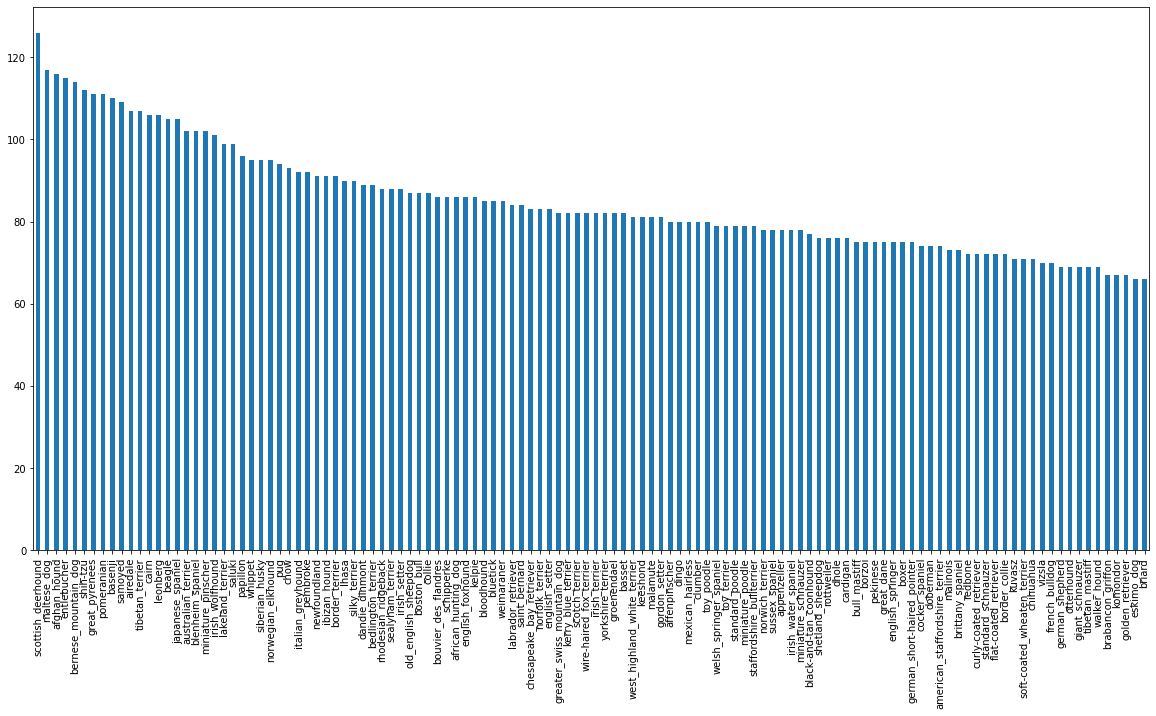

In [7]:
# How many images are there of each breed
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

In [8]:
# Check the median
labels_csv["breed"].value_counts().median() 

82.0

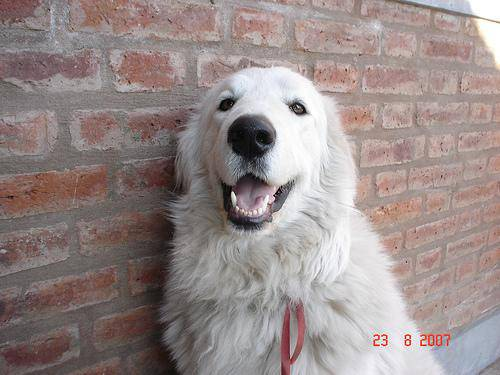

In [9]:
# Let's view an image
from IPython.display import Image
Image("drive/MyDrive/Dog Vision/train/0a0c223352985ec154fd604d7ddceabd.jpg")

### Getting images and their labels

Let's get a list of all of our images pathnames.

In [10]:
# Create pathnames from images ID's in labels_csv data frame
filenames = ["drive/MyDrive/Dog Vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10
filenames[:10]

['drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [11]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("drive/MyDrive/Dog Vision/train")) == len(filenames):
  print("Filenames match the actual amount of files!!! Procceed.")
else:
  print("Filenames do not match actual amount of files, check the target directory")

Filenames match the actual amount of files!!! Procceed.


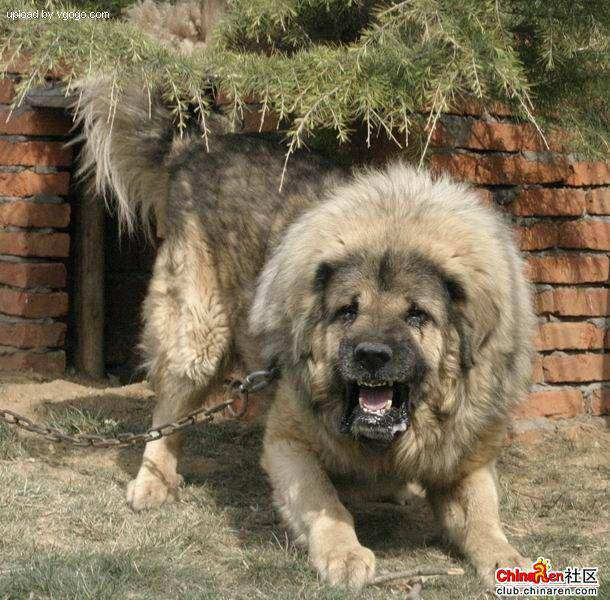

In [12]:
# View some random index image
Image(filenames[9000])

In [13]:
# Check the breed of dog at 9000 index
labels_csv["breed"][9000]

'tibetan_mastiff'

Since we've now got our training images filepaths in a list, let's prepare our labels

In [14]:
labels = np.array(labels_csv["breed"])
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [15]:
len(labels)

10222

In [16]:
# See if number of labels matches number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches with number of filenames!!")
else:
  print("Number of labels doesn't match with number of filenames. Check data directories")

Number of labels matches with number of filenames!!


### Turn our data labels into numbers

In [17]:
# Find the unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [18]:
len(unique_breeds)

120

In [19]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [20]:
# Turn every label into an array of booleans
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [21]:
len(boolean_labels)

10222

In [22]:
# Turning boolean array in intergers
print(labels[0]) # Origin
print(np.where(unique_breeds == labels[0])) # Index where label occurs
print(boolean_labels[0].argmax()) # Index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # There will be 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set

Since the dataset from Kaggle doesn't come with a validation set, we are going to create our own.

In [23]:
# Setup X and Y variables
X = filenames
Y = boolean_labels

We are going to start experimenting with ~1000 images and increase as needed.

In [24]:
# Set the number of images to use for experimenting by ceating a slider param using Colab
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [25]:
# Let's split our data into train and test
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, Y_train, Y_val = train_test_split(X[:NUM_IMAGES], 
                                                  Y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(Y_train), len(X_val), len(Y_val)

(800, 800, 200, 200)

In [26]:
len(boolean_labels)

10222

In [27]:
# Let's have a geez at the training data
X_train[:5], Y_train[:2]

(['drive/MyDrive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/MyDrive/Dog Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/MyDrive/Dog Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/MyDrive/Dog Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, 

### Preprocessing Images (turning images into tensors)

To pre-process our images into the Tensors we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use the TensorFlow to read the file and save it to a vaiable 'image'
3. Turn our 'image' (a JPG) into Tensors
4. Normalize our image (convert color channel values 0-255 to 0-1)
5. Resize the 'image' to be a shape of (224, 224)
6. Return the modified 'image'

TensorFlow Data Loading: https://www.tensorflow.org/tutorials/load_data/images

Before we do, let's see what importing an image looks like

In [28]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

Check colour channel in image

In [29]:
image

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  53],
        [ 97,  88,  49],
        [120, 111,  72]]

In [30]:
image.max()

255

In [31]:
# Convert image NumPy array into Tensor
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  5

Now we've seen how an image looks like a tensor, let's create a function to preprocess them.

In [32]:
# Define image size
IMG_SIZE = 224
# Create a fuction for pre-proccessing images
def process_image(image_path, image_size=IMG_SIZE):
  """
  Take an image file path and turns the image into a Tensor
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the JPG image into numerical Tensor with 3 color channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the color channel values from 0-255 to 0-1 (Normalization) 
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired shape that is (224, 224)
  image = tf.image.resize(image, size=[image_size, image_size])
  return image

In [33]:
process_image(filenames[32])

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[2.1821149e-02, 9.6624352e-02, 3.9579429e-02],
        [3.1774971e-01, 3.9849764e-01, 3.4007537e-01],
        [1.9432701e-02, 7.9156667e-02, 2.5785400e-02],
        ...,
        [0.0000000e+00, 2.8685225e-02, 7.3815696e-03],
        [1.9170513e-03, 4.3444425e-02, 1.0881329e-02],
        [1.4592139e-02, 6.1650965e-02, 2.2435278e-02]],

       [[1.0875124e-01, 1.8718261e-01, 1.4012378e-01],
        [1.7272735e-04, 4.8262980e-02, 1.3897762e-03],
        [6.4935260e-02, 1.2673499e-01, 8.3912849e-02],
        ...,
        [1.0160362e-04, 1.2352975e-02, 9.8086741e-05],
        [1.2390460e-02, 5.1494777e-02, 2.0159349e-02],
        [2.1063086e-02, 6.0197882e-02, 2.8852297e-02]],

       [[5.7045318e-02, 1.2597509e-01, 7.8916252e-02],
        [1.0413458e-02, 6.4111114e-02, 2.4974126e-02],
        [1.2249038e-02, 6.4907044e-02, 2.5636028e-02],
        ...,
        [2.1364415e-02, 4.3656677e-02, 1.5458719e-02],
        [1.4683082e-02

### Turning our data into batches

Why turn our data into batches?
Let's say you're trying to process 10000+ images in one go.... They all might not fit into the memory

So that's why we do about 32 (this is the batch size) images at a time (you can manually adjust batch size if need be)

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which looks like this:
'(image, label)'

In [34]:
# Create a simple function to return a tuple of Tensor (image, label)
def get_image_label(image_path, label):
  """
  Take an image file path and the associated label,
  proccesses the image and returns a tuple of (image, label)
  """
  image = process_image(image_path)
  return image, label

In [35]:
# Demo of the above function
get_image_label(X[42], tf.constant(Y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of Tensors in the form '(image, label)', let's make a function to turn all of our data ('X' and 'Y') into batches.

In [36]:
# Define the batch size
BATCH_SIZE = 32

# Create a function to data into batches
def create_data_batches(X, Y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Create the batches of data out of image (X) and label (Y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts Test Data as input (no labels).
  """
  # If the data is test data set we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices(tf.constant(X)) # Only filepaths no labels
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch 
  # If the data is a valid data set, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches....")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(Y))) 
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch
  # It means this is a training batch
  else:
    print("Creating training data batches....")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(Y)))
    # Shuffle the pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))
    # Create (image, label) tuples (this also turns the image path into a pre-proccessed image) 
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

In [37]:
# Create training and validation data batches
train_data = create_data_batches(X_train, Y_train)
val_data = create_data_batches(X_val, Y_val, valid_data=True)

Creating training data batches....
Creating validation data batches....


In [38]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [39]:
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

### Visualizing Our Data Batches

Our data is now in batches, however, these can be a little hard to understand/comprehend, let's visualize them. 

In [40]:
import matplotlib.pyplot as plt
# Create a function for viewing images in a databatch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch
  """
  # Setup the figure
  plt.figure(figsize=(10,10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the gridlines off
    plt.axis("off")

In [41]:
# Batchify our data
train_images, train_labels = next(train_data.as_numpy_iterator())
train_images, train_labels

(array([[[[0.8898818 , 0.8545877 , 0.78909665],
          [0.8753606 , 0.84398806, 0.7996603 ],
          [0.785039  , 0.7545352 , 0.74300045],
          ...,
          [0.9399161 , 0.89285725, 0.8373251 ],
          [0.94200265, 0.94632137, 0.89125866],
          [0.9718717 , 0.98410773, 0.92741394]],
 
         [[0.947031  , 0.9117369 , 0.8521001 ],
          [0.9247355 , 0.89093506, 0.85146314],
          [0.9301248 , 0.89938253, 0.8885632 ],
          ...,
          [0.99292964, 0.9458709 , 0.89033866],
          [0.9766664 , 0.9546362 , 0.9024837 ],
          [0.9633044 , 0.94653666, 0.89293975]],
 
         [[0.8672412 , 0.8292051 , 0.7786074 ],
          [0.89174455, 0.85937744, 0.8243333 ],
          [0.96230656, 0.9307834 , 0.92667985],
          ...,
          [0.96939963, 0.9223408 , 0.8668086 ],
          [0.88402355, 0.8318702 , 0.7865096 ],
          [0.9242628 , 0.8672776 , 0.8243329 ]],
 
         ...,
 
         [[0.848961  , 0.8019022 , 0.70778453],
          [0.88256

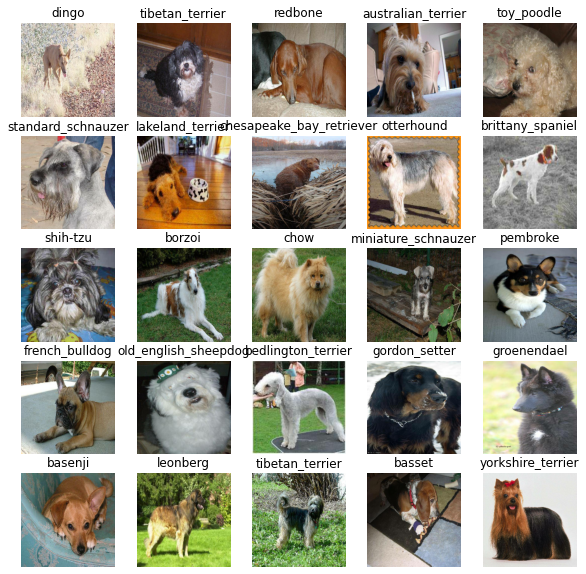

In [42]:
# Now let's visualize the data in a training batch
show_25_images(train_images, train_labels)

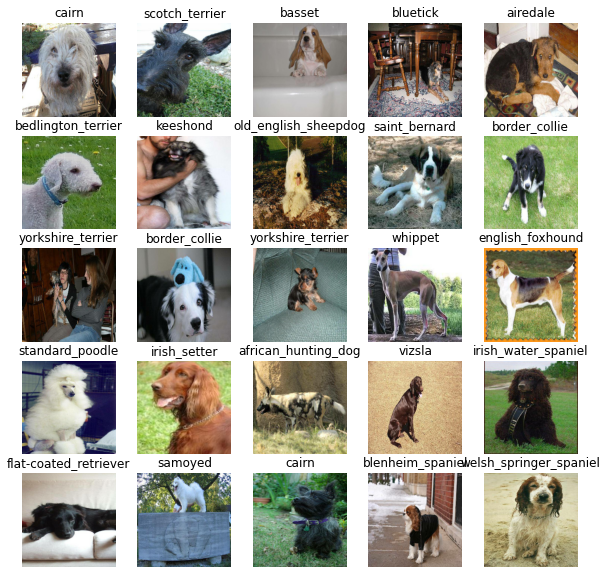

In [43]:
# Now let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model

Before we build a model, there are a few things we need to define:
1. The input shape (our images shape, in the form of Tensors) to our model
2. The output shape (image labels, in the form of Tensors) to our model
3. The URL of the model we want to use from TensorFlow Hub (https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5)

In [44]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # Batch, Height, Width,Color Channels
# Setup output shape to the model
OUTPUT_SHAPE = len(unique_breeds) # Unique Breeds, 
# Setup model URL from the TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

Now we've got our inputs, outputs and model ready to go. Let's put them together in Keras Deep Learning Model.

Knowing this, let's create a function which:
1. Takes the input shape, output shape, and the model we've chosen as parameter
2. Defines the layers in a Keras model in sequential fashion (do this fisrt, then this, then that)
3. Compiles the model (says it should be evaluated and improved)
4. Builds the model (tells the model the input shape it'll be getting)
5. Returns the model

All of this documentation can be found at: https://keras.io/getting_started/


In [45]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with: ", model_url)
  
  # Setup the model layers
  model = tf.keras.Sequential([
                               hub.KerasLayer(model_url), # Layer 1 (Input Layer)
                               tf.keras.layers.Dense(units=output_shape,
                                                     activation="softmax") # Layer 2 (Output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(input_shape)

  return model

In [46]:
# Create the model using custom function
model = create_model()
model.summary()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


In [47]:
outputs = np.ones(shape=(1,1,1280))
outputs

array([[[1., 1., 1., ..., 1., 1., 1.]]])

#### Check MobileNet V2 architecture
https://towardsdatascience.com/review-mobilenetv2-light-weight-model-image-classification-8febb490e61c

## Creating callbacks

Callbacks are helper functions a model can use during training to do such things as save it's progress, check it's progress, or stop training early if a model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our model's progress and another for early stopping which prevents our model from training for too long.



### TensorBoard Callback

To setup a TensorBoard callback, we need to do three things
1. Load the TensorBoard notebook extension
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's 'fit()' function.
3. Visualize our model's training logs with the '%tensorboard' magic function (we'll do this after model training).

In [48]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [49]:
import datetime
# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for saving TensorBoard logs
  logdir = os.path.join("drive/MyDrive/Dog Vision/logs",
                         # Make it so the logs get tracked whenever we run an experiment
                         datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early stopping callback

Early stopping helps stop our model from overfitting by stopping training if a cetain evaluation matrix stops improving. 

https://keras.io/api/callbacks/early_stopping/



In [50]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## Training a model (on subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.


In [51]:
# Set number of epochs 
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10} 


In [52]:
# Check to make sure we're still running on GPU
print("GPU", "Available(Yes!!!!)" if tf.config.list_physical_devices("GPU") else "not available")

GPU Available(Yes!!!!)


#### Let's create a function which trains a model

* Create a model using 'create_model()'
* Setup a TensorBoard callback using 'create_tensorboard_callback()' 
* Call the 'fit()' function on our model passing it the training data, validation data, number of epochs to train for which is 'NUM_EPOCHS'and the callbacks we'd like to use.
* Return the model


In [53]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  
  # Return the fitted model
  return model

In [54]:
# Fit the model to the data
model = train_model()


Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/100
25/25 [==============================] - 139s 4s/step - loss: 4.5128 - accuracy: 0.1175 - val_loss: 3.2634 - val_accuracy: 0.2900
Epoch 2/100
25/25 [==============================] - 4s 161ms/step - loss: 1.5990 - accuracy: 0.6975 - val_loss: 2.1226 - val_accuracy: 0.5300
Epoch 3/100
25/25 [==============================] - 4s 162ms/step - loss: 0.5627 - accuracy: 0.9388 - val_loss: 1.6538 - val_accuracy: 0.5950
Epoch 4/100
25/25 [==============================] - 3s 135ms/step - loss: 0.2587 - accuracy: 0.9837 - val_loss: 1.4569 - val_accuracy: 0.6200
Epoch 5/100
25/25 [==============================] - 4s 158ms/step - loss: 0.1491 - accuracy: 0.9950 - val_loss: 1.3671 - val_accuracy: 0.6550
Epoch 6/100
25/25 [==============================] - 3s 139ms/step - loss: 0.1023 - accuracy: 0.9987 - val_loss: 1.3201 - val_accuracy: 0.6550
Epoch 7/100
25/25 [==============================

**Question:** It looks like our model is overfitting because it's performing far better on the training dataset then the validation dataset. What are some ways to prevent overfitting in deep learning neural networks?

**Note:** Overfitting to begin with is a good thing, it mean our model is learning!!!

### Checking the TensorBoard logs

The TensorBoard magic function '%tensorboard' will access the logs directory we ceated earlier and visualize its contents.

In [55]:
%tensorboard --logdir drive/MyDrive/Dog\ Vision/logs

<IPython.core.display.Javascript object>

## Making and evaluating predictions using a trained model


In [56]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 1s 106ms/step


array([[1.7995639e-03, 1.7942650e-04, 2.4123716e-03, ..., 6.8532693e-04,
        4.4405755e-05, 3.3930787e-03],
       [8.6863618e-04, 5.1832316e-04, 3.1374499e-02, ..., 7.8695790e-05,
        4.1546994e-03, 5.2652922e-05],
       [4.4350409e-06, 2.0630150e-04, 4.5516932e-05, ..., 4.2044965e-05,
        9.1258735e-06, 4.6912846e-06],
       ...,
       [2.8644581e-06, 2.8613578e-05, 7.1859204e-06, ..., 2.3565008e-05,
        2.8395267e-05, 1.9141306e-05],
       [6.2808208e-03, 2.0572364e-04, 4.4890959e-04, ..., 2.9789202e-04,
        1.1629617e-04, 1.0980168e-02],
       [9.1908092e-04, 1.4283216e-05, 6.0866534e-04, ..., 5.6064758e-03,
        5.1451119e-04, 1.6883991e-04]], dtype=float32)

In [57]:
predictions.shape

(200, 120)

In [58]:
predictions[0]

array([1.79956388e-03, 1.79426497e-04, 2.41237157e-03, 5.32941704e-05,
       8.54926766e-05, 3.62297542e-05, 6.28063381e-02, 8.37878688e-05,
       3.32310126e-04, 2.12610117e-03, 2.52837170e-04, 2.28163917e-05,
       2.41004644e-04, 4.57000060e-05, 1.99425442e-04, 7.16906652e-05,
       2.92495097e-04, 1.22245982e-01, 4.53856446e-05, 1.68738861e-05,
       1.29290420e-04, 6.56447606e-04, 4.20943943e-05, 1.39974453e-03,
       1.01606813e-04, 8.27630720e-05, 3.56613308e-01, 7.57151574e-05,
       1.14917639e-04, 1.28820146e-04, 1.56105125e-05, 1.12852280e-03,
       2.10496379e-04, 2.79924461e-05, 5.98816296e-05, 2.67128088e-02,
       2.53974886e-05, 1.69247432e-04, 1.13816706e-04, 4.50183179e-05,
       3.18713603e-04, 3.77941797e-05, 1.93734231e-04, 1.53463276e-04,
       4.33888854e-05, 7.95157684e-05, 1.33344101e-05, 1.70951589e-05,
       1.97704096e-04, 3.71189788e-04, 7.03575643e-05, 3.77045399e-05,
       7.05921266e-05, 1.61386255e-04, 1.44424994e-04, 1.49059433e-05,
      

In [59]:
np.sum(predictions[0])

0.9999999

In [60]:
# First prediction
index = 0
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum:{np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[1.79956388e-03 1.79426497e-04 2.41237157e-03 5.32941704e-05
 8.54926766e-05 3.62297542e-05 6.28063381e-02 8.37878688e-05
 3.32310126e-04 2.12610117e-03 2.52837170e-04 2.28163917e-05
 2.41004644e-04 4.57000060e-05 1.99425442e-04 7.16906652e-05
 2.92495097e-04 1.22245982e-01 4.53856446e-05 1.68738861e-05
 1.29290420e-04 6.56447606e-04 4.20943943e-05 1.39974453e-03
 1.01606813e-04 8.27630720e-05 3.56613308e-01 7.57151574e-05
 1.14917639e-04 1.28820146e-04 1.56105125e-05 1.12852280e-03
 2.10496379e-04 2.79924461e-05 5.98816296e-05 2.67128088e-02
 2.53974886e-05 1.69247432e-04 1.13816706e-04 4.50183179e-05
 3.18713603e-04 3.77941797e-05 1.93734231e-04 1.53463276e-04
 4.33888854e-05 7.95157684e-05 1.33344101e-05 1.70951589e-05
 1.97704096e-04 3.71189788e-04 7.03575643e-05 3.77045399e-05
 7.05921266e-05 1.61386255e-04 1.44424994e-04 1.49059433e-05
 6.83255566e-05 2.90437229e-03 1.42697361e-03 1.40531421e-01
 1.06559841e-04 9.03842920e-06 2.61633424e-03 5.60434673e-05
 3.46549750e-05 1.540770

In [61]:
unique_breeds[26]

'cairn'

### Transform Predictions To Text

Having the above functionality is great but we want to be able to do it at scale.
And it would be even better if we could see the image the prediction is being made on.

**Note:** Prediction probabilities are also known as confidence levels

In [62]:
# Turn prediction probabilities into their respective labels (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of predictions probabilities into a label
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities 
pred_label = get_pred_label(predictions[81])
pred_label

'irish_terrier'

### Now since our validation data is still in batch dataset we'll have to un-batch it to make predictions on the validation images and compare those predictions to the validation labels (truth labels)

In [67]:
# Create a function to un-batch a batch data set
def unbatchify(data):
  """
  Takes a batch dataset of (image,label) Tensors and separate arrays of images and labels 
  """
  images = []
  labels = []
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation dataset
val_images_, val_labels_ = unbatchify(val_data)
val_images_[0], val_labels_[0], get_pred_label(val_labels_[0])

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

## Visualizing Model Predictions

Now we've got ways to get:
* Prediction labels
* Validation labels and 
* Validation images 

Now let's make some function to make it all more visual.

We'll create a function which:
* Takes an array of prediction probabilities, an array of truth labels and an array of images and integes.
* Convert the prediction probability to predicted label.
* Plot the predicted label, it's predicted probability, the truth label and the target image on a single plot.


In [70]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred_label
  pred_label = get_pred_label(pred_prob)

  # Plot image and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on the if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
            color=color) 

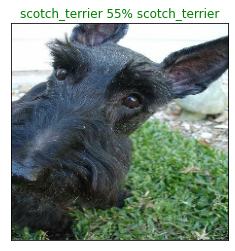

In [71]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels_,
          images=val_images_)

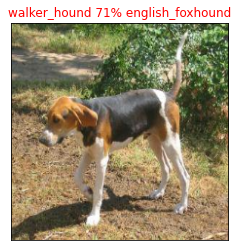

In [74]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels_,
          images=val_images_,
          n=42)

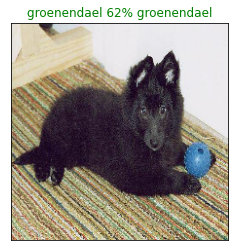

In [75]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels_,
          images=val_images_,
          n=77)

Now we've got a function to visualize our model's top pediction. Let's create another function to visualize our model's top 10 predictions.

This function will:
* Take an input of prediction probabilities array, a ground truth array, and an integer.
* Find the predicted label using 'get_pred_label' function.
* Find the top 10:
  * Prediction probability indexes
  * Prediction probability values
  * Prrediction labels
* Plot the top 10 prediction probability values and labels, colouring the true label green.

In [86]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plot the top 10 highest prediction confidences along with the truth labels for sample n
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted labels
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_prob_indexes = pred_prob.argsort()[-10:][::-1]

  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_prob_indexes]

  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_prob_indexes]

  # Setup a plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change the color of true labels
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

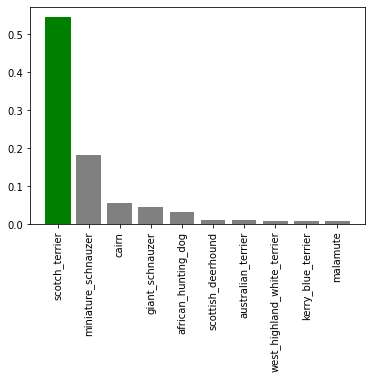

In [87]:
plot_pred_conf(prediction_probabilities=predictions, 
               labels=val_labels_,
               n=1)

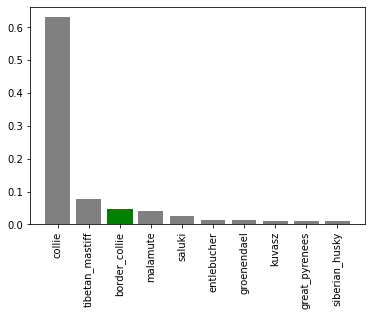

In [88]:
plot_pred_conf(prediction_probabilities=predictions, 
               labels=val_labels_,
               n=9)

Now we've got some functions to help us visualize our predictions and evaluate our model. Let's checkout a few.

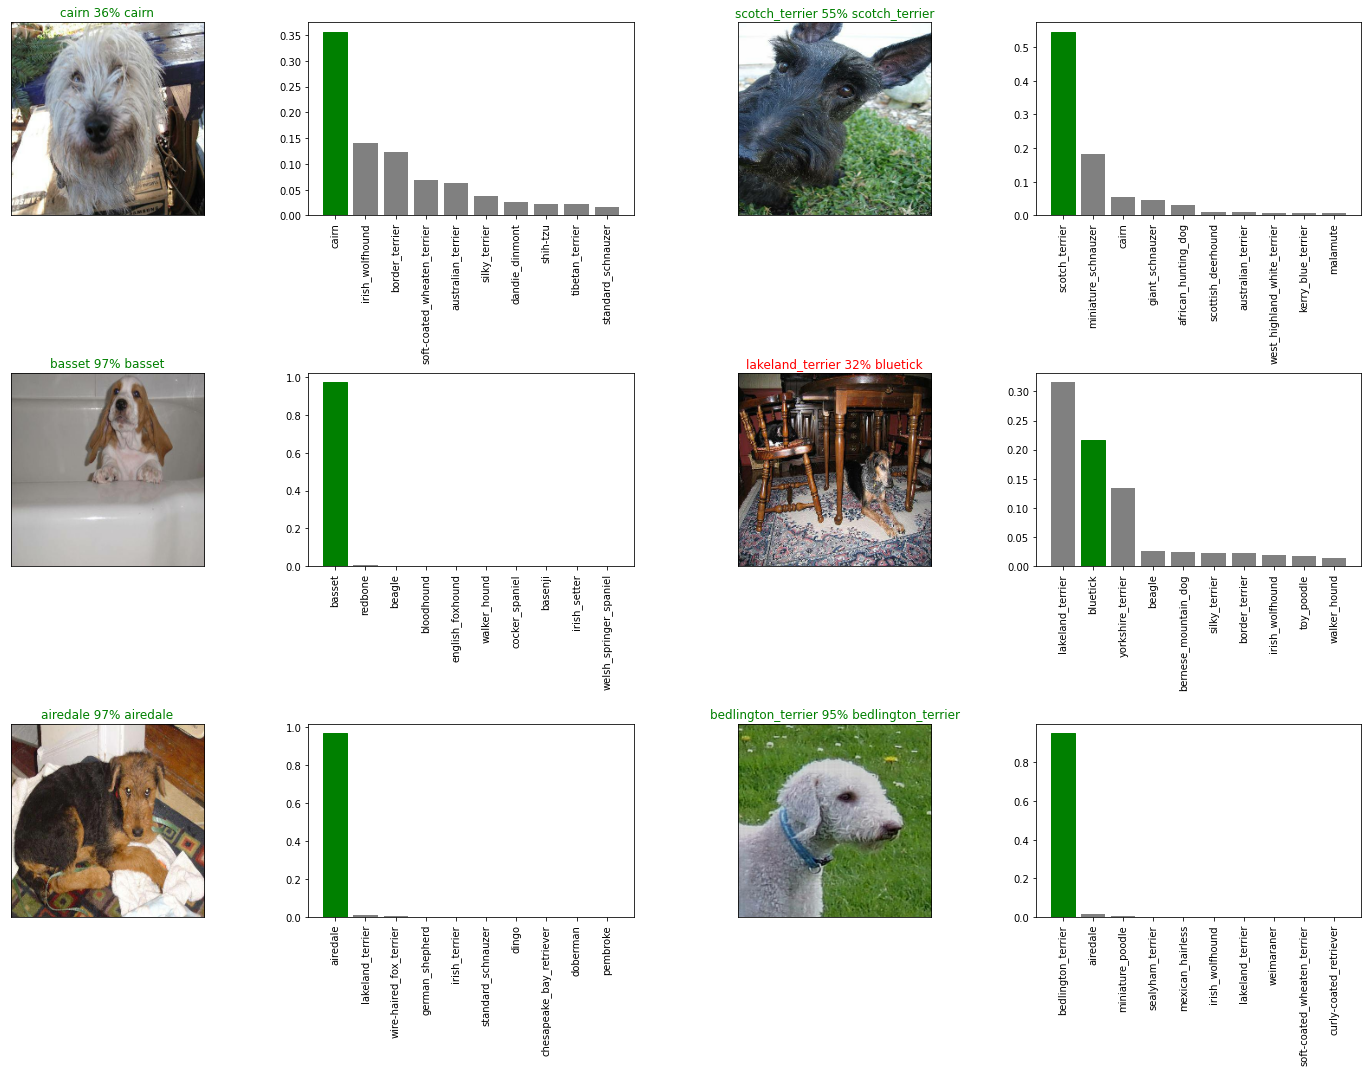

In [94]:
# Let's checkout a few predictions and their different values
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols

plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels_,
            images=val_images_,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels_,
                 n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

**Challenge:** How would you create a confusion matrix with our model's predictions and true labels?

## Saving and loading a trained model


In [102]:
# Let's crate a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix string
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/MyDrive/Dog Vision/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  modelpath = modeldir + "-" + suffix + ".h5" # This is the save format of the model
  print(f"Saving model to {modelpath}....")
  model.save(modelpath)
  return modelpath

In [103]:
# Let's create a function to load a trained model
def load_model(modelpath):
  """
  Loads a saved model from a specified path
  """
  print(f"Loading saved model from {modelpath}...")
  model = tf.keras.models.load_model(modelpath, custom_objects={"KerasLayer":hub.KerasLayer})
  return model


Now we've got functions to save and load a model. Let's make sure they work.

In [104]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to drive/MyDrive/Dog Vision/models/20210714-06061626242790-1000-images-mobilenetv2-Adam.h5....


'drive/MyDrive/Dog Vision/models/20210714-06061626242790-1000-images-mobilenetv2-Adam.h5'

In [105]:
# Load a trained model
loaded_1000_images_model = load_model("drive/MyDrive/Dog Vision/models/20210714-06061626242790-1000-images-mobilenetv2-Adam.h5")

Loading saved model from drive/MyDrive/Dog Vision/models/20210714-06061626242790-1000-images-mobilenetv2-Adam.h5...


In [106]:
# Evaluate pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 90ms/step - loss: 1.2155 - accuracy: 0.6750


[1.2154520750045776, 0.675000011920929]

In [107]:
# Evaluate loaded model
loaded_1000_images_model.evaluate(val_data)

7/7 [==============================] - 1s 100ms/step - loss: 1.2155 - accuracy: 0.6750


[1.2154520750045776, 0.675000011920929]

## Train the model on full training dataset

In [108]:
len(X), len(Y)

(10222, 10222)

In [109]:
type(X)

list

In [110]:
X[:10]

['drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [111]:
len(X_train)

800

In [112]:
# Create a data batch with the full dataset
full_data = create_data_batches(X, Y)

Creating training data batches....


In [113]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [115]:
# Create a model for full model
full_model = create_model()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


In [116]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

**Note:** Running the below cell will take a little while (maybe upto 30 minutes for the first epoch) because the GPU we're using in the runtime has to load all of the images into memory.

In [117]:
# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 1187s 4s/step - loss: 1.3285 - accuracy: 0.6725
Epoch 2/100
320/320 [==============================] - 31s 96ms/step - loss: 0.4033 - accuracy: 0.8801
Epoch 3/100
320/320 [==============================] - 31s 96ms/step - loss: 0.2361 - accuracy: 0.9345
Epoch 4/100
320/320 [==============================] - 31s 95ms/step - loss: 0.1556 - accuracy: 0.9623
Epoch 5/100
320/320 [==============================] - 31s 95ms/step - loss: 0.1062 - accuracy: 0.9794
Epoch 6/100
320/320 [==============================] - 31s 96ms/step - loss: 0.0761 - accuracy: 0.9875
Epoch 7/100
320/320 [==============================] - 31s 96ms/step - loss: 0.0589 - accuracy: 0.9905
Epoch 8/100
320/320 [==============================] - 31s 96ms/step - loss: 0.0467 - accuracy: 0.9943
Epoch 9/100
320/320 [==============================] - 31s 97ms/step - loss: 0.0362 - accuracy: 0.9964
Epoch 10/100
320/320 [==============================] - 31s 98ms/step - l

In [118]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to drive/MyDrive/Dog Vision/models/20210714-07201626247237-full-image-set-mobilenetv2-Adam.h5....


'drive/MyDrive/Dog Vision/models/20210714-07201626247237-full-image-set-mobilenetv2-Adam.h5'

In [119]:
loaded_full_model = load_model("drive/MyDrive/Dog Vision/models/20210714-07201626247237-full-image-set-mobilenetv2-Adam.h5")

Loading saved model from drive/MyDrive/Dog Vision/models/20210714-07201626247237-full-image-set-mobilenetv2-Adam.h5...


## Making predictions on the test dataset

Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

Lickily we created 'create_data_batches()' function earlier, which can take a list of filenames as input and convert them into Tensor batches. 

To make predictions on the test data:
* Get the test image filenames
* Convert the filenames into test data batches using 'create_data_batches()' and setting the 'test_data' parameter to 'True' (Since the test data doesn't have labels).
* Make a prediction array by passing the test batches to the 'predict()' method called on our model.



In [120]:
# Load test image filenames
test_path = "drive/MyDrive/Dog Vision/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['drive/MyDrive/Dog Vision/test/dfc0659b3b6eff35dc50d2501f1ea247.jpg',
 'drive/MyDrive/Dog Vision/test/e53cb5b42ea1a7700cd294a336890361.jpg',
 'drive/MyDrive/Dog Vision/test/dccc6c6c2f8cb55631b6ce664bf21fee.jpg',
 'drive/MyDrive/Dog Vision/test/dcab2d03a686ab3f31d1bc3e5700f6d1.jpg',
 'drive/MyDrive/Dog Vision/test/de4223b8c5ca7b80d34d1cd2b5e62351.jpg',
 'drive/MyDrive/Dog Vision/test/e379ba26a5e2e22e85975b839e0e401b.jpg',
 'drive/MyDrive/Dog Vision/test/e17512584de423da7fc17bfb2c7548ae.jpg',
 'drive/MyDrive/Dog Vision/test/e0295b9b1bee725d52d74f9af84092cf.jpg',
 'drive/MyDrive/Dog Vision/test/e2628b6bde028b5eb593616128728907.jpg',
 'drive/MyDrive/Dog Vision/test/dcbe4226672aa4af80c1e52a9bb78268.jpg']

In [121]:
len(test_filenames)

10357

In [122]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [123]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

**Note:** Calling predict on our full model and passing it the test data batch will take a long time to run (about ~an hour).  

In [124]:
# Make predictions on test data batch using the loaded_full_model
test_predictions = loaded_full_model.predict(test_data, verbose=1)

324/324 [==============================] - 1289s 4s/step


In [125]:
# Save predictions (NumPy array) to CSV file for access later
np.savetxt("drive/MyDrive/Dog Vision/preds_array.csv", test_predictions, delimiter=',') 

In [126]:
# Load predictions (NumPy array) from CSV
loaded_test_predictions = np.loadtxt("drive/MyDrive/Dog Vision/preds_array.csv", delimiter=',')

In [127]:
loaded_test_predictions[:10]

array([[1.53754576e-09, 5.49061063e-09, 8.83510192e-12, ...,
        4.72603068e-09, 2.72556289e-08, 1.02873251e-03],
       [2.55490247e-11, 1.71856505e-11, 8.82599202e-11, ...,
        4.25247235e-05, 2.18449500e-07, 1.38843488e-08],
       [2.63588484e-09, 5.54479531e-13, 9.46743972e-15, ...,
        4.05040029e-11, 2.59492124e-12, 7.50705401e-11],
       ...,
       [6.01455330e-09, 4.57555672e-07, 3.93418453e-09, ...,
        1.84217515e-05, 1.18593180e-05, 1.16557416e-07],
       [1.92992422e-09, 1.41841117e-09, 1.15349008e-09, ...,
        1.57977393e-05, 4.38943260e-07, 7.18700767e-06],
       [1.00493992e-06, 1.22635886e-11, 3.19761595e-09, ...,
        5.99024048e-08, 6.38530950e-10, 2.28590299e-10]])

In [128]:
loaded_test_predictions.shape

(10357, 120)

## Prepaing test data set predictions for Kaggle

**Submission File**
For each image in the test set, you must predict a probability for each of the different breeds. The file should contain a header and have the following format:

id,affenpinscher,afghan_hound,..,yorkshire_terrier

000621fb3cbb32d8935728e48679680e,0.0083,0.0,...,0.0083
etc.

Looking at the Kaggle sample submission file, we find that it wants our model's prediction probability in DataFrame with an ID, and a column for each dog breed. 

To get the data in this format:
* Create a pandas DataFrame with an id column as well as a column for each dog breed.
* Add data to the id column by extracting the test image ids from their filepaths.
* Add data (prediction probabilities) to each of the dog breed column.
* Export the DataFrame as CSV to submit it to Kaggle.


In [129]:
# Create a DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"]+list(unique_breeds))

In [131]:
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [133]:
test_filenames[:5]

['drive/MyDrive/Dog Vision/test/dfc0659b3b6eff35dc50d2501f1ea247.jpg',
 'drive/MyDrive/Dog Vision/test/e53cb5b42ea1a7700cd294a336890361.jpg',
 'drive/MyDrive/Dog Vision/test/dccc6c6c2f8cb55631b6ce664bf21fee.jpg',
 'drive/MyDrive/Dog Vision/test/dcab2d03a686ab3f31d1bc3e5700f6d1.jpg',
 'drive/MyDrive/Dog Vision/test/de4223b8c5ca7b80d34d1cd2b5e62351.jpg']

In [136]:
# Get the test_ids from test_path
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
test_ids[:10]

['dfc0659b3b6eff35dc50d2501f1ea247',
 'e53cb5b42ea1a7700cd294a336890361',
 'dccc6c6c2f8cb55631b6ce664bf21fee',
 'dcab2d03a686ab3f31d1bc3e5700f6d1',
 'de4223b8c5ca7b80d34d1cd2b5e62351',
 'e379ba26a5e2e22e85975b839e0e401b',
 'e17512584de423da7fc17bfb2c7548ae',
 'e0295b9b1bee725d52d74f9af84092cf',
 'e2628b6bde028b5eb593616128728907',
 'dcbe4226672aa4af80c1e52a9bb78268']

In [138]:
# Append test image ids to the predictions data frame
preds_df["id"] = test_ids
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,dfc0659b3b6eff35dc50d2501f1ea247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,e53cb5b42ea1a7700cd294a336890361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,dccc6c6c2f8cb55631b6ce664bf21fee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,dcab2d03a686ab3f31d1bc3e5700f6d1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,de4223b8c5ca7b80d34d1cd2b5e62351,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [139]:
# Add the prediction probability to each dog breed column
preds_df[list(unique_breeds)] = loaded_test_predictions
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,dfc0659b3b6eff35dc50d2501f1ea247,1.53755e-09,5.49061e-09,8.8351e-12,0.00292957,0.0454179,0.00726922,0.00367154,2.12823e-07,3.03827e-07,8.02616e-07,7.71025e-11,2.07376e-06,5.04711e-06,1.03549e-07,1.29206e-06,1.85093e-05,1.11301e-08,1.13949e-08,9.40584e-09,1.07239e-08,1.1925e-10,7.4042e-09,0.000240003,4.73113e-10,9.37556e-07,6.13992e-07,9.6242e-13,1.64142e-08,3.56032e-07,1.38853e-06,2.93943e-06,1.52614e-07,3.70873e-05,2.26136e-06,1.29908e-08,7.62971e-07,4.75935e-10,1.56191e-07,0.00896957,...,7.43946e-06,1.10622e-09,1.4782e-09,7.36812e-07,2.66203e-08,1.37488e-06,1.94187e-07,4.93822e-07,2.50303e-07,6.88692e-07,1.70106e-05,0.841703,8.48191e-09,1.14425e-08,4.40625e-09,1.76308e-07,1.58408e-10,7.09223e-07,4.14918e-10,5.70483e-07,4.52657e-11,1.13663e-07,3.37273e-06,2.23066e-09,1.67427e-05,5.18522e-07,5.32033e-06,4.66563e-10,9.61472e-07,3.69311e-07,1.15562e-07,1.03624e-05,1.93982e-06,0.000782385,3.86734e-07,2.06194e-05,2.28407e-07,4.72603e-09,2.72556e-08,0.00102873
1,e53cb5b42ea1a7700cd294a336890361,2.5549e-11,1.71857e-11,8.82599e-11,2.70518e-08,0.00193826,5.23467e-10,0.00010321,0.00668143,0.813657,0.000415724,5.40864e-10,8.17963e-11,2.20229e-09,1.17164e-07,5.30847e-08,2.18144e-08,3.90273e-10,7.66993e-09,2.26927e-12,4.04759e-11,5.56361e-13,0.000231637,3.48565e-08,3.28892e-13,9.68264e-08,1.23783e-09,1.56708e-08,4.51256e-08,4.71726e-09,4.02438e-10,3.5738e-07,3.26314e-10,1.80837e-09,1.87373e-10,3.77489e-09,8.78211e-07,1.04851e-08,1.26298e-10,4.23267e-08,...,2.65669e-09,6.08422e-10,7.20698e-09,8.81877e-08,1.34805e-09,4.19293e-10,8.37728e-08,1.41871e-11,1.85394e-09,4.0448e-06,4.39354e-07,1.50902e-11,2.95292e-09,2.13169e-08,1.6022e-08,1.52367e-13,4.34569e-10,1.24577e-11,2.47905e-09,2.54298e-06,6.69674e-09,9.59592e-11,2.51707e-10,1.91603e-09,1.80097e-11,1.93081e-07,7.40522e-08,1.2946e-11,9.06314e-11,4.22257e-09,7.17643e-09,1.13054e-09,1.80115e-08,1.3227e-05,1.96718e-09,2.29747e-05,2.30477e-10,4.25247e-05,2.1845e-07,1.38843e-08
2,dccc6c6c2f8cb55631b6ce664bf21fee,2.63588e-09,5.5448e-13,9.46744e-15,1.20788e-09,6.86927e-10,2.97176e-08,9.47662e-11,1.74749e-10,3.90012e-11,1.67707e-10,3.97165e-13,2.55099e-11,7.58545e-11,8.59205e-08,1.52337e-09,3.31799e-09,1.22705e-12,5.11141e-07,5.72704e-15,2.06793e-08,2.00763e-12,4.51871e-06,0.999991,1.51204e-14,2.38483e-11,6.03444e-08,6.88317e-12,1.43158e-11,1.30305e-09,4.60981e-08,9.46289e-12,4.14569e-11,5.6913e-11,3.36173e-13,1.39264e-12,6.80722e-12,1.11059e-11,3.78594e-10,4.82189e-11,...,4.06675e-11,6.14547e-13,1.43122e-11,6.42869e-13,3.53334e-10,5.7993e-09,7.82392e-13,1.61246e-11,1.81434e-07,2.63816e-06,6.46547e-10,2.29677e-11,1.05495e-10,7.99499e-13,3.56159e-11,1.18715e-11,1.01506e-13,1.56725e-13,6.36064e-11,2.45769e-11,2.85883e-09,9.72865e-13,3.53431e-09,1.18964e-10,3.7788e-10,6.17715e-10,6.73229e-10,1.50387e-09,3.42314e-11,8.12575e-12,6.63782e-10,9.68856e-09,3.22895e-09,3.0114e-10,9.52952e-13,2.41973e-09,1.34718e-12,4.

In [140]:
# Export predictions data frame into csv for submission to Kaggle
preds_df.to_csv("drive/MyDrive/Dog Vision/full_model_predictions_submission_1_mobilenetv2_.csv", 
                index=False)

## Make predictions on custom images

To make predictions on custom images, we'll:
* Get the filepaths of our own images.
* Turn the filepaths into data batches using 'create_data_batches()' function, and sicne our custom image don't have labels, we set the 'test_data' parameter to 'True'.
* Pass the custom image data batch to our model's 'predict()' function.
* Convert the prediction output probabilities to prediction labels.
* Compare the predicted labels to the custom images.


In [158]:
# Get the custom image filepaths
custom_path = "drive/MyDrive/Dog Vision/my-dog-photos/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [149]:
custom_image_paths

['drive/MyDrive/Dog Vision/my-dog-photos/IMG_20210611_155308.jpg',
 'drive/MyDrive/Dog Vision/my-dog-photos/1614333417283-01.jpeg',
 'drive/MyDrive/Dog Vision/my-dog-photos/IMG_20210711_213029.jpg']

In [159]:
# Turn custom image into Data Batches
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [160]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

In [161]:
custom_preds.shape

(3, 120)

In [162]:
# Get custom image prediction labels 
custom_preds_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_preds_labels

['pomeranian', 'samoyed', 'samoyed']

In [163]:
# Get custom images (our unbatchify() function won't work since there aren't labels...maybe we could fix this later).
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

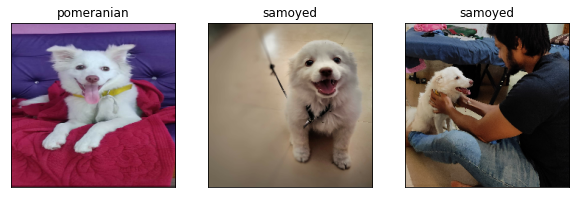

In [164]:
# Check custom image prediction
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_preds_labels[i])
  plt.imshow(image)